In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('intersection_label.csv')
df.image = df.image.apply(lambda x: x.split('-')[-1])
df.drop(columns=["annotation_id", "created_at", "annotator", "updated_at", "id", "lead_time"], inplace=True)

In [4]:
df.head()

,choice,image
0,Intersection,00001.png
1,Intersection,00237.png
2,Intersection,00296.png
3,Intersection,00355.png
4,Intersection,00414.png


In [106]:
len(df)

716

In [5]:
output_dir = Path("/Users/mo/Documents/sample/output/GH021415/")
image_dir = output_dir / "images"
yolo_dir = output_dir / "runs/detect/yolo/labels"
crosswalk_dir = output_dir / "runs/detect/crosswalk/labels"

In [6]:
p = list(image_dir.glob("*"))[0]
with open(crosswalk_dir / f"00001.txt") as f:
    lines = f.readlines()
lines

['Zebra_Cross 0.707292 0.769907 0.585417 0.456481 0.817059\n']

In [7]:
def read_label(path):
    labels = []
    if path.exists():
        with open(path, "r") as f:
            lines = f.readlines()
            for line in lines:
                words = line.strip("\n").split(" ")
                if len(words) == 7:
                    labels.append([words[0] + words[1]] + words[2:])
                else:
                    labels.append(words)
    return labels

dic = []
for p in image_dir.glob("*"):
    crosswalk_labels = read_label(crosswalk_dir / f"{p.stem}.txt")
    yolo_labels = read_label(yolo_dir / f"{p.stem}.txt")
    for cls, x, y, w, h, conf in crosswalk_labels + yolo_labels:
        dic.append({
            "image": p.name,
            "label": cls if cls != "Zebra_Cross" else "Crosswalk",
            "x": x,
            "y": y,
            "w": w,
            "h": h,
            "conf": conf
            })
df_label = pd.DataFrame(dic)
df_label["x"] = df_label["x"].astype(float)
df_label["y"] = df_label["y"].astype(float)
df_label["w"] = df_label["w"].astype(float)
df_label["h"] = df_label["h"].astype(float)
df_label["conf"] = df_label["conf"].astype(float)
df_label.head()

,image,label,x,y,w,h,conf
0,03836.png,bus,0.932031,0.338426,0.135937,0.186111,0.514542
1,03836.png,person,0.835677,0.449537,0.072396,0.171296,0.866111
2,03836.png,person,0.724740,0.600000,0.253646,0.792593,0.964231
3,22185.png,person,0.903906,0.406019,0.013021,0.056481,0.302876
4,22185.png,person,0.943750,0.423148,0.023958,0.090741,0.647504


In [8]:
df_all = df.join(df_label.set_index("image"), on="image")
len(df_all)

7184

In [9]:
df_all.groupby("label")["conf"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Crosswalk,343.0,0.723242,0.217550,0.250440,0.581770,0.821338,0.898623,0.950467
R_Signal,23.0,0.362733,0.089786,0.256801,0.288698,0.340328,0.429270,0.548094
bicycle,43.0,0.467097,0.166021,0.254357,0.330784,0.432971,0.601890,0.794616
bus,72.0,0.545913,0.232670,0.250888,0.325358,0.512959,0.754638,0.946008
car,2534.0,0.605513,0.214404,0.250348,0.409779,0.618389,0.794714,0.960240
motorcycle,24.0,0.383222,0.119861,0.255706,0.301486,0.357650,0.430398,0.773271
person,4002.0,0.728303,0.223764,0.250049,0.557518,0.815087,0.924767,0.975363
stopsign,4.0,0.374830,0.114744,0.267375,0.285035,0.362685,0.452480,0.506578
trafficlight,138.0,0.404857,0.138595,0.250497,0.302324,0.361135,0.469728,0.822149


In [10]:
vehicles = ['car', 'bicycle', 'bus', 'motorcycle']
signs = ['trafficlight', "R_Signal", "stopsign"]

In [11]:
df_all[df_all["label"] == "trafficlight"]

,choice,image,label,x,y,w,h,conf
0,Intersection,00001.png,trafficlight,0.632031,0.435648,0.023438,0.039815,0.406896
0,Intersection,00001.png,trafficlight,0.632031,0.435648,0.023438,0.039815,0.406896
7,Intersection,00591.png,trafficlight,0.605469,0.374537,0.019271,0.034259,0.311885
7,Intersection,00591.png,trafficlight,0.605469,0.374537,0.019271,0.034259,0.311885
8,Intersection,00650.png,trafficlight,0.592708,0.381944,0.014583,0.034259,0.319697
...,...,...,...,...,...,...,...,...
635,Sidewalk,37643.png,trafficlight,0.074479,0.264815,0.051042,0.127778,0.699465
675,Sidewalk,40003.png,trafficlight,0.967969,0.059722,0.064062,0.119444,0.261776
687,Intersection,40711.png,trafficlight,0.859375,0.332870,0.013542,0.026852,0.399233
688,Intersection,40770.png,trafficlight,0.866667,0.293981,0.041667,0.039815,0.437465


In [12]:
# All intersection images containing vehicles
df_all[df_all["choice"] == "Intersection"].groupby("image").filter(lambda x: not x["label"].isin(vehicles).any())

,choice,image,label,x,y,w,h,conf


In [13]:
# Some sidewalk images containing vehicles
df_all[(df_all["label"] == "car") & (df_all["choice"] == "Sidewalk")]

,choice,image,label,x,y,w,h,conf
52,Sidewalk,03246.png,car,0.961458,0.329167,0.073958,0.073148,0.450904
52,Sidewalk,03246.png,car,0.977604,0.368981,0.044792,0.130556,0.663940
52,Sidewalk,03246.png,car,0.205990,0.617130,0.048438,0.065741,0.703760
52,Sidewalk,03246.png,car,0.131250,0.741204,0.261458,0.310185,0.933578
53,Sidewalk,03305.png,car,0.042969,0.646759,0.036979,0.060185,0.269066
...,...,...,...,...,...,...,...,...
710,Sidewalk,42068.png,car,0.969792,0.392130,0.042708,0.056481,0.414483
711,Sidewalk,42127.png,car,0.991667,0.412963,0.015625,0.075926,0.453938
711,Sidewalk,42127.png,car,0.975000,0.397222,0.050000,0.087037,0.546695
712,Sidewalk,42186.png,car,0.988802,0.375000,0.021354,0.044444,0.373417


In [14]:
yolo_dir.parent / "42068.png"

PosixPath('/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/42068.png')

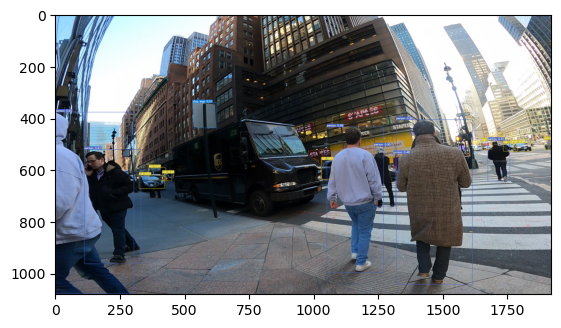

In [15]:
# stop sign sample
image = plt.imread(yolo_dir.parent / "30445.png")
plt.imshow(image)

In [16]:
df_all.groupby("label").agg({"conf": "mean"})

,conf
label,
Crosswalk,0.723242
R_Signal,0.362733
bicycle,0.467097
bus,0.545913
car,0.605513
motorcycle,0.383222
person,0.728303
stopsign,0.374831
trafficlight,0.404857


In [17]:
df_all.groupby("image").filter(filter_func).drop_duplicates("image")["choice"].value_counts()

NameError: name 'filter_func' is not defined

In [ ]:
# only count person, vehicle, crosswalk

def filter_func(x):
    labels = x["label"].values
    return "person" in labels and "Crosswalk" in labels and x["label"].isin(vehicles).any()

df_all.groupby("image").filter(filter_func).drop_duplicates("image")["choice"].value_counts()

choice
Intersection    230
Sidewalk         79
Name: count, dtype: int64

In [18]:
df_counts = df_all.groupby(["image", "label"]).size().unstack().fillna(0).astype(int)
df_counts.reset_index(inplace=True)
df_counts = df_counts.join(df.set_index("image"), on="image")

In [19]:
df_counts.columns

Index(['image', 'Crosswalk', 'R_Signal', 'bicycle', 'bus', 'car', 'motorcycle',
       'person', 'stopsign', 'trafficlight', 'choice'],
      dtype='object')

In [21]:
df_counts["choice"] = df_counts["choice"].apply(lambda x: 1 if x == "Intersection" else 0)

In [145]:
from sklearn.linear_model import LogisticRegression
X = df_counts[["person", "Crosswalk", "car", "bicycle", "bus", "motorcycle", "trafficlight", "R_Signal", "stopsign"]].values
Y = df_counts[['choice']].values.reshape(-1, 1)
linear_regressor = LogisticRegression(warm_start=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

/opt/homebrew/Caskroom/miniconda/base/envs/xc/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [146]:
linear_regressor.score(X, Y)

0.9118881118881119

In [154]:
import numpy as np
decision = X[0] @ linear_regressor.coef_.T + linear_regressor.intercept_
print(linear_regressor.predict_proba(X[:1]))
decision

[[2.85817670e-06 9.99997142e-01]]


array([12.7653238])

In [143]:
for coef, name in zip(linear_regressor.coef_[0], ["person", "Crosswalk", "car", "bicycle", "bus", "motorcycle", "trafficlight", "R_Signal", "stopsign"]):
    print(f'"{name}"',":", coef, ",")
print("b=", linear_regressor.intercept_[0])

"person" : 0.029059253808071544 ,
"Crosswalk" : 1.9603206961676414 ,
"car" : 0.6355884872452348 ,
"bicycle" : -0.14292570898554718 ,
"bus" : 1.321341465227851 ,
"motorcycle" : 0.5133643421888616 ,
"trafficlight" : 1.2932466508582567 ,
"R_Signal" : -0.03577319755800458 ,
"stopsign" : -0.8425573763203269 ,
b= -4.958208007282151


In [144]:
# combine vehicles, signs
df_agg_count = df_counts.copy()
df_agg_count["vehicle"] = df_agg_count[["car", "bicycle", "bus", "motorcycle"]].sum(axis=1)
df_agg_count["sign"] = df_agg_count[["trafficlight", "R_Signal", "stopsign"]].sum(axis=1)
X = df_agg_count[["person", "Crosswalk", "vehicle", "sign"]].values
Y = df_agg_count[['choice']].values.reshape(-1, 1)
linear_regressor = LogisticRegression(warm_start=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
linear_regressor.score(X, Y)

/opt/homebrew/Caskroom/miniconda/base/envs/xc/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9020979020979021

In [71]:
for coef, name in zip(linear_regressor.coef_[0], ["person", "Crosswalk", "vehicle", "sign"]):
    print(f"{name}:", "{:.2f}".format(coef))

person: 0.03
Crosswalk: 1.95
vehicle: 0.63
sign: 0.99


# With condifence version

In [171]:
df_conf_counts = df_all.groupby(["image", "label"]).agg({"conf": "sum"}).unstack().fillna(0).astype(float)
df_conf_counts = df_conf_counts.droplevel(0, axis=1).reset_index()
df_conf_counts = df_conf_counts.join(df.set_index("image"), on="image")
df_conf_counts.head()

,image,Crosswalk,R_Signal,bicycle,bus,car,motorcycle,person,stopsign,trafficlight,choice
0,00001.png,0.817059,0.0,0.000000,0.0,12.077234,0.0,6.386688,0.0,0.813792,Intersection
1,00237.png,0.822383,0.0,0.000000,0.0,13.514546,0.0,7.313608,0.0,0.000000,Intersection
2,00296.png,0.879979,0.0,0.000000,0.0,12.271184,0.0,3.248762,0.0,0.000000,Intersection
3,00355.png,0.895149,0.0,1.434160,0.0,10.834894,0.0,3.778526,0.0,0.000000,Intersection
4,00414.png,0.914546,0.0,1.589232,0.0,14.410072,0.0,4.827972,0.0,0.000000,Intersection


In [181]:
df_conf_counts["choice"] = df_conf_counts["choice"].apply(lambda x: 1 if x == "Intersection" else 0)

In [182]:
X = df_conf_counts[["person", "Crosswalk", "car", "bicycle", "bus", "motorcycle", "trafficlight", "R_Signal", "stopsign"]].values
Y = df_conf_counts[['choice']].values.reshape(-1, 1)
linear_regressor = LogisticRegression(warm_start=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
linear_regressor.score(X, Y)

/opt/homebrew/Caskroom/miniconda/base/envs/xc/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9370629370629371

In [183]:
df_conf_counts[['choice']].values

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [184]:
for coef, name in zip(linear_regressor.coef_[0], ["person", "Crosswalk", "car", "bicycle", "bus", "motorcycle", "trafficlight", "R_Signal", "stopsign"]):
    print(f'"{name}"',":", coef, ",")
print("b=", linear_regressor.intercept_[0])

"person" : 0.008687173316285312 ,
"Crosswalk" : 3.3470720555129185 ,
"car" : 0.9916819493912497 ,
"bicycle" : 0.4772582269590735 ,
"bus" : 1.9100436819742963 ,
"motorcycle" : 0.2392703359735101 ,
"trafficlight" : 1.8459140771948266 ,
"R_Signal" : 0.12295418615641256 ,
"stopsign" : -0.45393678624340095 ,
b= -4.909474292254606


In [174]:
Y_pred

array(['Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Intersection',
       'Intersection', 'Intersection', 'Intersection', 'Sidewalk',
       'Sidewalk', 'Sidewalk', 'Sidewalk', 'Sidewalk', 'Sidewalk',
       'Sidewa

In [160]:
result = pd.DataFrame([Y_pred.reshape(-1), Y.reshape(-1), df_conf_counts["image"]]).T.rename({0: "pred", 1: "actual", 2: "image"}, axis=1)
result

,pred,actual,image
0,Intersection,Intersection,00001.png
1,Intersection,Intersection,00237.png
2,Intersection,Intersection,00296.png
3,Intersection,Intersection,00355.png
4,Intersection,Intersection,00414.png
...,...,...,...
710,Sidewalk,Sidewalk,42127.png
711,Sidewalk,Sidewalk,42186.png
712,Sidewalk,Sidewalk,42245.png
713,Sidewalk,Sidewalk,42304.png


In [165]:
result[result["pred"] != result["actual"]].__len__()

45

In [166]:
df_TN = result[(result["pred"] =="Sidewalk") &  (result["actual"] == "Intersection")]
print(len(df_TN))
for i, (pred, actual, image) in df_TN.iterrows():
    print(yolo_dir.parent / f"{image}", crosswalk_dir.parent / f"{image}")

20
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/03187.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/03187.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/10621.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/10621.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/11978.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/11978.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/12037.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/12037.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/15105.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/15105.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/18114.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/18114.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/21241.png /Users/mo/Documents/sample/output/GH021415/runs/detect/cr

In [167]:
df_FP = result[(result["pred"] =="Intersection") &  (result["actual"] == "Sidewalk")]
print(len(df_FP))
for i, (pred, actual, image) in df_FP.iterrows():
    print(yolo_dir.parent / f"{image}", crosswalk_dir.parent / f"{image}")

25
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/05665.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/05665.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/05724.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/05724.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/05783.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/05783.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/05842.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/05842.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/12214.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/12214.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/14397.png /Users/mo/Documents/sample/output/GH021415/runs/detect/crosswalk/14397.png
/Users/mo/Documents/sample/output/GH021415/runs/detect/yolo/14456.png /Users/mo/Documents/sample/output/GH021415/runs/detect/cr

In [132]:
len(linear_regressor.coef_[0])

4

In [133]:
X.shape

(715, 4)

In [136]:
linear_regressor.intercept_

array([4.94669001])

In [84]:
# combine vehicles, signs
df_agg_count = df_conf_counts.copy()
df_agg_count["vehicle"] = df_agg_count[["car", "bicycle", "bus", "motorcycle"]].sum(axis=1)
df_agg_count["sign"] = df_agg_count[["trafficlight", "R_Signal", "stopsign"]].sum(axis=1)
X = df_agg_count[["person", "Crosswalk", "vehicle", "sign"]].values
Y = df_agg_count[['choice']].values.reshape(-1, 1)
linear_regressor = LogisticRegression(warm_start=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
linear_regressor.score(X, Y)

/opt/homebrew/Caskroom/miniconda/base/envs/xc/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9314685314685315

In [85]:
for coef, name in zip(linear_regressor.coef_[0], ["person", "Crosswalk", "vehicle", "sign"]):
    print(f"{name}:", "{:.2f}".format(coef))

person: -0.01
Crosswalk: -3.29
vehicle: -1.03
sign: -1.65


In [202]:
intersection_dir = output_dir / "runs/detect/intersection/labels"

def read_label(p):
    with open(p, "r") as f:
        return [p.stem + '.png'] + f.read().strip().split(", ")

labels = [read_label(p) for p in intersection_dir.glob("*.txt")]
df_intersection = pd.DataFrame(labels, columns=["image", "prob", "processed"])
df_intersection["processed"] = df_intersection["processed"].astype(int)
df_intersection["log"] = Y_pred
df_intersection["y"] = Y

In [207]:
df_corrected = df_intersection[(df_intersection["log"] != df_intersection["processed"]) & (df_intersection["processed"] == df_intersection["y"])]
print(f"After postprocessing, {len(df_corrected)} has been corrected.")

After postprocessing, 20 has been corrected.


In [210]:
df_mislabeled = df_intersection[(df_intersection["log"] != df_intersection["processed"]) & (df_intersection["processed"] == df_intersection["log"])]
print(f"After postprocessing, {len(df_mislabeled)} has been changed label wrongly.")

After postprocessing, 0 has been changed label wrongly.


In [211]:
df_not_corrected = df_intersection[(df_intersection["log"] == df_intersection["processed"]) & (df_intersection["processed"] != df_intersection["y"])]
print(f"After postprocessing, {len(df_not_corrected)} has not been corrected.")

After postprocessing, 25 has not been corrected.
